In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,ConfusionMatrixDisplay

In [2]:
def pad_image(image_path,target_size):
  img = Image.open(image_path).convert('RGB')
  resized_img = T.Resize(target_size,max_size=300)(img)
  padding = get_padding_sizes(resized_img,target_size)
  result = T.Pad(padding,0,"constant")(resized_img)
  return result,(image_path,result.size)

def get_padding_sizes(image, target_size):
  width, height = image.size
  hor_pad_size = target_size - width      # yatay olarak padding alanı boyutu
  ver_pad_size = target_size - height     # düşey olarak padding alanı boyutu
  padding_left = hor_pad_size//2
  padding_right = hor_pad_size - padding_left
  padding_top = ver_pad_size//2
  padding_bottom = ver_pad_size - padding_top
  padding = (padding_left,padding_top,padding_right,padding_bottom)
  return padding

def sort_image_list(lst):
  new_lst = []
  extensions = {}
  for i in range(0,len(lst)):
    id = Path(lst[i]).stem
    extensions[id] = lst[i][-4:]
    new_lst.append(int(id))

  new_lst = sorted(new_lst)

  for i in range(0,len(lst)):
    id = str(new_lst[i])
    new_lst[i]= id + extensions[id]
  return new_lst

def display_images_errors(imgs_lst,labels_file):
  new_img_lst = sort_image_list(imgs_lst)
  return pd.DataFrame({
      "image" : [img for img in new_img_lst],
      "id" : [labels_file.iloc[i,0] for i in range(0,len(labels_file))],
      "Error" : [labels_file.iloc[i,1] for i in range(0,len(labels_file))],
      "Type" : [labels_file.iloc[i,2] for i in range(0,len(labels_file))]
      })

def display_images_labels(imgs_lst,image_label_dictionary):
  return pd.DataFrame({
      "Image" : [img for img in imgs_lst],
      "Label" : [image_label_dictionary[img] for img in imgs_lst]
  })

def create_images_list(dir,sort=False,fullPath=False):
  lst = os.listdir(dir)

  if sort:
    lst = sort_image_list(lst)

  if fullPath:
    for i,img in enumerate(lst):
      path = os.path.join(dir,img)
      lst[i] = path

  return lst

def merge_image_directories(dir1,dir2,sort=False,fullPath=False):
  list1 = create_images_list(dir1,sort,fullPath)
  list2 = create_images_list(dir2,sort,fullPath)
  total = list1 + list2
  return total

def get_selected_indexes(indexes:list,elements:list):
  arr = []
  for idx in indexes:
    arr.append(elements[idx])
  return arr

## Image list must be sorted before call this function.
## For sorting call sort_image_list function before.
def create_img_label_dict(imgs_lst,labels_lst,column_num:int):
  _dict = {}
  for i,img in enumerate(imgs_lst):
    _dict[img] = labels_lst.iloc[i,column_num]
  return _dict

def create_cm(actual_labels,predicted,classes):
  cm = confusion_matrix(actual_labels, predicted)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  cm_display.plot()
  plt.title('Confusion Matrix')
  plt.show()

In [3]:
furkan_images_dir = "/content/drive/MyDrive/Ara_proje_dataset/Furkan_Pan/images"
gamze_images_dir = "/content/drive/MyDrive/Ara_proje_dataset/Gamze_Pan/images"
furkan_excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Furkan_Pan/Furkan_Excel.xlsx"
gamze_excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Gamze_Pan/Gamze_Excel.xlsx"
total_excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Total_Excel.xlsx"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = T.Compose([T.ToTensor(),T.Normalize([0.5], [0.2])])
classes = ["Hatasız","Hatalı"]
new_size = 224      ## Must be less than max_size=512

In [4]:
labels_file = pd.read_excel(total_excel_path,header=None,keep_default_na=False)
images_paths = merge_image_directories(furkan_images_dir,gamze_images_dir,sort=True,fullPath=True)
img_lbl_dict = create_img_label_dict(images_paths,labels_file,column_num=1)
pd.Series({
    "labels file length =" : len(labels_file),
    "images list length =" : len(images_paths),
    "dictionary  length =" : len(img_lbl_dict)
}).to_frame().style.hide(axis='columns')

labels file length =,1497
images list length =,1497
dictionary length =,1497


In [5]:
total_images_paths = images_paths.copy()
images_paths = random.sample(images_paths,1400)
len(images_paths),len(total_images_paths)

(1400, 1497)

In [6]:
def findRepeatedElements(arr):
  i=0
  repeated = []
  while i<len(arr)-1:
    found = search(arr,i,-1)
    if found!=-1:
      repeated.append(found)
    i+=1
  return repeated

def search(arr,idx,element):
  if element ==-1:
    j=idx+1
    element = arr[idx]
  else:
    j=0
  while j<len(arr):
    if element == arr[j]:
      return element
    else:
      j+=1
  return -1

def getNotFoundElements(arr1,arr2):
  not_found= []
  for elm in arr1:
    xx = search(arr2,-1,elm)
    if xx ==-1:
      not_found.append(elm)
  return not_found

In [7]:
print(findRepeatedElements(images_paths))
test_images = getNotFoundElements(total_images_paths,images_paths)
print(len(test_images))

[]
97


In [8]:
display_images_labels(images_paths,img_lbl_dict)

,Image,Label
0,/content/drive/MyDrive/Ara_proje_dataset/Gamze...,0
1,/content/drive/MyDrive/Ara_proje_dataset/Gamze...,1
2,/content/drive/MyDrive/Ara_proje_dataset/Furka...,0
3,/content/drive/MyDrive/Ara_proje_dataset/Furka...,0
4,/content/drive/MyDrive/Ara_proje_dataset/Gamze...,1
...,...,...
1395,/content/drive/MyDrive/Ara_proje_dataset/Furka...,1
1396,/content/drive/MyDrive/Ara_proje_dataset/Furka...,0
1397,/content/drive/MyDrive/Ara_proje_dataset/Furka...,1
1398,/content/drive/MyDrive/Ara_proje_dataset/Furka...,0


/content/drive/MyDrive/Ara_proje_dataset/Furkan_Pan/images/2078.jpg (224, 100)


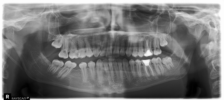

In [9]:
img_path = random.choice(images_paths)
img = Image.open(img_path)
img = T.Resize((100,224))(img)
print(img_path,img.size)
img

('/content/drive/MyDrive/Ara_proje_dataset/Furkan_Pan/images/2078.jpg', (224, 224))


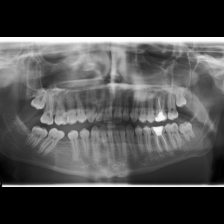

In [10]:
img, info = pad_image(img_path,224)
print(info)
img

In [11]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 167MB/s]


In [12]:
class ImageDataset(Dataset):
  def __init__(self, img_paths, img_lbl_dict , transform=None):
    self.img_paths = img_paths
    self.image_label_dictionary = img_lbl_dict
    self.transform = transform

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    global new_size
    result = pad_image(self.img_paths[idx],new_size)
    label = self.image_label_dictionary[self.img_paths[idx]]
    if self.transform:
        image = self.transform(result[0])
    return image, label

class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, len(classes))
        )

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x

In [13]:
model = DinoVisionTransformerClassifier().to(device)        ## Initialize model
loss_func = nn.CrossEntropyLoss()                           ## loss function
optimizer = optim.AdamW(model.parameters(),lr=3e-5)         ## optimizer
batch_size = 20                                             ## batch size
num_epochs = 10                                             ## number of epochs
K = 5                                                       ## Folds number
kf = KFold(n_splits=K)                                      ## Define K-Fold method for cross validation

In [14]:
def run_epoch(num_epochs,epoch_id,model,dataloader,is_training):
    acc, lossValue, corrects, count= 0, 0, 0, 0
    loop = tqdm(dataloader)                                  ## Show progress bar for train loop.
    ## Set model mode to train.
    model.train()
    for idx, sample in enumerate(loop):                    ## iterate whole train dataset with batches.
      ## Get images and their corresponding labels.
      imgs, labels = sample
      imgs = imgs.to(device)
      labels = labels.to(device)

      if is_training:
        optimizer.zero_grad()                             ## Reset grads to zero.

      outputs = model(imgs)                               ## make predictions

      predictions = outputs.argmax(dim=1, keepdim=True).squeeze() ## Get highest probability predicted class for each input sample.
      count += len(predictions)
      corrects += (predictions == labels).sum().item()    ## Count the correct predictions.

      ## Calculate loss value.
      loss = loss_func(outputs,labels)
      if is_training:
        loss.backward()                                   ## Calculate gradiants of the loss.
        optimizer.step()                                  ## Update optimizer parameters.

      lossValue += loss.item()                            ## Get loss value.
      acc = corrects/count
      avg_loss = lossValue/len(dataloader)
      ## Update progress bar.
      if is_training:
        loop.set_description(f"Epoch: [{epoch+1}/{num_epochs}]")
      else:
        loop.set_description("Evaluation Step:")
      loop.set_postfix(Avg_Loss= avg_loss, Loss = loss.item(), Accuracy = acc)

    return acc, avg_loss

In [15]:
## Train loop
losses = []
acc = []
for i, (train_index, test_index) in enumerate(kf.split(images_paths)):
  print(f"Fold {i+1}/{K}")
  ## Get select items for train/test folds.
  x_train = get_selected_indexes(train_index,images_paths)
  x_test  = get_selected_indexes(test_index,images_paths)

  ## Initialize train/test dataset instances.
  train_dataset = ImageDataset(x_train,img_lbl_dict,transform)
  test_dataset = ImageDataset(x_test,img_lbl_dict,transform)
  #print(f"train dataset length: {len(train_dataset)} , test dataset length: {len(test_dataset)}")

  ## Initialize train/test dataloaders.
  train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=2,shuffle=True)
  test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers=2,shuffle=True)
  #print(f"Number of batches in train DataLoader: {len(train_dataloader)}, Number of batches in test DataLoader: {len(test_dataloader)}")
  t_acc, t_avg_loss, v_acc, v_avg_loss = None, None, None, None
  for epoch in range(0,num_epochs):
    ## Set model mode to train.
    model.train()
    t_acc, t_avg_loss = run_epoch(num_epochs,epoch,model,train_dataloader,True)   ## Run epoch

    ## Set model mode to evaluation.
    ## all steps like above in training mode but for evaluate model on test dataset.
    model.eval()
    with torch.no_grad():
      v_acc, v_avg_loss = run_epoch(None,None,model,test_dataloader,False)        ## Evaluate model

  ## Store metrics.
  acc.append(v_acc)
  losses.append(v_avg_loss)


Fold 1/5


Evaluation Step:: 100%|██████████| 14/14 [00:17<00:00,  1.28s/it, Accuracy=0.539, Avg_Loss=0.761, Loss=0.841]


Fold 2/5


Evaluation Step:: 100%|██████████| 14/14 [00:19<00:00,  1.36s/it, Accuracy=0.846, Avg_Loss=0.46, Loss=0.699]


Fold 3/5


Evaluation Step:: 100%|██████████| 14/14 [00:17<00:00,  1.28s/it, Accuracy=0.954, Avg_Loss=0.126, Loss=0.263]


Fold 4/5


Evaluation Step:: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it, Accuracy=0.996, Avg_Loss=0.0188, Loss=0.0052]


Fold 5/5


Evaluation Step:: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it, Accuracy=0.993, Avg_Loss=0.0249, Loss=0.0396]


In [16]:
print("Model Performance:")
print(f"Model average loss:{sum(losses)/len(losses)}, Model average Accuracy: {100*sum(acc)/len(acc)}%")

Model Performance:
Model average loss:0.2779923041622948, Model average Accuracy: 86.57142857142858%


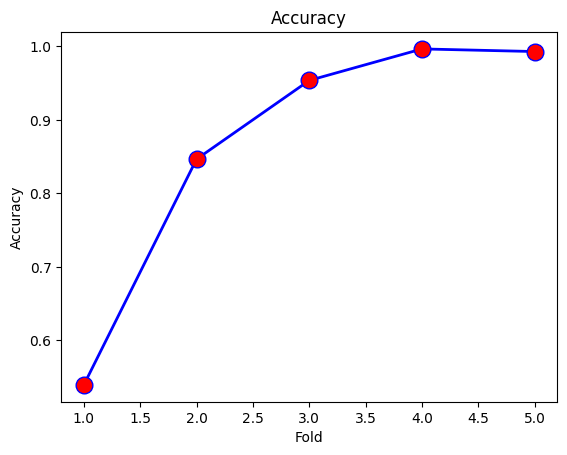

In [17]:
plt.plot(range(1,K+1),acc,color="blue",linewidth = 2,marker='o', markerfacecolor='red', markersize=12)
plt.title("Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.show()

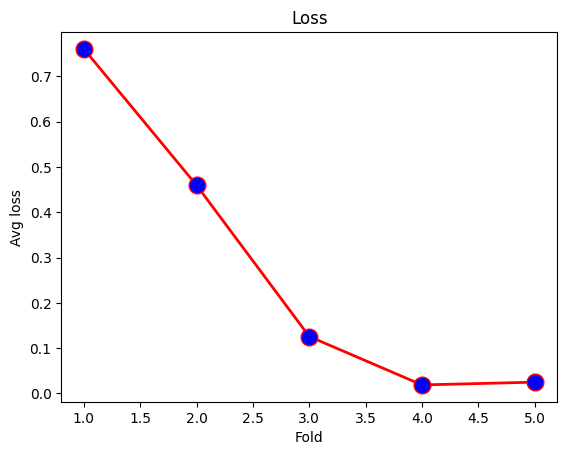

In [18]:
plt.plot(range(1,K+1),losses,color='red',linewidth=2,marker='o', markerfacecolor='blue', markersize=12)
plt.title("Loss")
plt.xlabel("Fold")
plt.ylabel("Avg loss")
plt.show()

In [ ]:
#g_images_paths = create_images_list(gamze_images_dir,sort=True,fullPath=True)
#g_labels = pd.read_excel(gamze_excel_path,header=None,keep_default_na=False)
#g_img_lbl_dict = create_img_label_dict(g_images_paths,g_labels,1)

In [19]:
test_data = ImageDataset(test_images,img_lbl_dict,transform)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)
total_samples = 0
test_labels = []
predicted = []
model.eval()
with torch.no_grad():
  for i, (imgs, labels) in enumerate(test_loader):
    imgs = imgs.to(device)
    labels = labels.to(device)
    outputs = model(imgs)
    predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
    total_samples += len(predictions)
    test_labels.extend(labels.tolist())
    predicted.extend(predictions.tolist())
print(f"Number of samples: {total_samples}")

Number of samples: 97


Accuracy: 0.5154639175257731, Precision: 0.5, Recall: 0.5319148936170213, F1 score: 0.5154639175257731


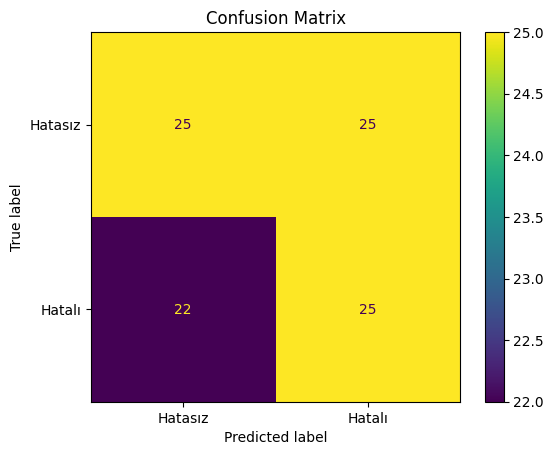

In [20]:
F1 = f1_score(test_labels,predicted)
precision = precision_score(test_labels,predicted)
recall = recall_score(test_labels,predicted)
accuracy = accuracy_score(test_labels,predicted)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 score: {F1}")
create_cm(test_labels,predicted,classes)